In [1]:
import tensorflow as tf
import tensorflow.keras.optimizers
import tensorflow.keras.metrics
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
from datetime import date, datetime, timedelta
import xarray as xr
import netCDF4 as nc
from ndays import numOfDays
import glob
import calendar
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import math
import u_interpolate_small as uint


2025-06-04 11:36:45.150160: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 11:36:45.159129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749033405.170407  176391 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749033405.174169  176391 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 11:36:45.186427: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Define domain and time period
# date is supposed to change automatically
current_date = '202408161500'


#--------------------------------
current_year = current_date[0:4]
current_month = current_date[4:6]
current_day = current_date[6:8]
t = 3 #numOfDays
leadtimes=[1,2,4,6]

# cords of interest ###### IMPORTANT#####
start_lat = 0  # 
end_lat = 21  #
start_lon = -20 #
end_lon = 1 
start_year = '2005'
end_year = '2019'


# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
reg_lat = np.arange(start_lat, end_lat, 0.04)
reg_lon = np.arange(start_lon, end_lon, 0.04) 


In [4]:
# get native MSG grid (core)
coords_filename = glob.glob('/prj/Africa_cloud/geoloc/*.npz')[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_latlon = np.load(coords_filename)
mlon = msg_latlon['lon']
mlat = msg_latlon['lat']

# find core indices using one file ###### IMPORTANT#####
lat_ind = np.where((mlat[:,10]>=start_lat) & (mlat[:,10]<=end_lat))[0]
lon_ind = np.where((mlon[1000,:]>=start_lon) & (mlon[1000,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]

# calculate interpolation weights from MSG (core) ###### IMPORTANT#####
inds, weights, shape = uint.interpolation_weights(lon, lat, reg_lon, reg_lat) # save weights for continuous use - MSG interpolation on regular. 

tir = np.zeros((t,len(lat[:,1]),len(lon[1,:])),dtype=float)
regridded_tir = np.zeros((t,len(reg_lat),len(reg_lon)),dtype=float) 
time_core = np.zeros((t)) 

In [5]:
def _create_mean_filter(half_num_rows, half_num_columns, num_channels):
    """Creates convolutional filter that computes mean.

    M = number of rows in filter
    N = number of columns in filter
    C = number of channels

    :param half_num_rows: Number of rows on either side of center.  This is
        (M - 1) / 2.
    :param half_num_columns: Number of columns on either side of center.  This
        is (N - 1) / 2.
    :param num_channels: Number of channels.
    :return: weight_matrix: M-by-N-by-C-by-C numpy array of filter weights.
    """

    num_rows = 2 * half_num_rows + 1
    num_columns = 2 * half_num_columns + 1
    weight = 1. / (num_rows * num_columns)

    return np.full(
        (num_rows, num_columns, num_channels, num_channels), weight,
        dtype=np.float32
    )

def FSS_loss(target_tensor, prediction_tensor):
    
    half_window_size_px=2
    use_as_loss_function=True 
    #mask_matrix
    function_name=None
    test_mode=False
    """Fractions skill score (FSS).

    M = number of rows in grid
    N = number of columns in grid

    :param half_window_size_px: Number of pixels (grid cells) in half of
        smoothing window (on either side of center).  If this argument is K, the
        window size will be (1 + 2 * K) by (1 + 2 * K).
    :param use_as_loss_function: Boolean flag.  FSS is positively oriented
        (higher is better), but if using it as loss function, we want it to be
        negatively oriented.  Thus, if `use_as_loss_function == True`, will
        return 1 - FSS.  If `use_as_loss_function == False`, will return just
        FSS.
    :param mask_matrix: M-by-N numpy array of Boolean flags.  Grid cells marked
        "False" are masked out and not used to compute the loss.
    :param function_name: Function name (string).
    :param test_mode: Leave this alone.
    :return: loss: Loss function (defined below).
    """

    weight_matrix = _create_mean_filter(
        half_num_rows=half_window_size_px,
        half_num_columns=half_window_size_px, num_channels=1
    )
       
    """Computes loss (fractions skill score).

        :param target_tensor: Tensor of target (actual) values.
        :param prediction_tensor: Tensor of predicted values.
        :return: loss: Fractions skill score.
    """

    smoothed_target_tensor = K.conv2d(
        x=target_tensor, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )

    smoothed_prediction_tensor = K.conv2d(
        x=prediction_tensor, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )

    actual_mse = K.mean(
        (smoothed_target_tensor - smoothed_prediction_tensor) ** 2
    )
    reference_mse = K.mean(
        smoothed_target_tensor ** 2 + smoothed_prediction_tensor ** 2
    )

    if use_as_loss_function:
        return actual_mse / reference_mse

    return 1. - actual_mse / reference_mse

    if function_name is not None:
        loss.__name__ = function_name


def spatial_filter_conv(predicted_image):
    
    half_window_size_px=2
    weight_matrix = _create_mean_filter(
        half_num_rows=half_window_size_px,
        half_num_columns=half_window_size_px, num_channels=1
    )

    smoothed_predicted_image = K.conv2d(
        x=predicted_image, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )
    return smoothed_predicted_image



In [6]:
from tensorflow.python.keras.engine import data_adapter

def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset

tf.config.run_functions_eagerly(True)

In [8]:
##### Define input shape
image_height= 512
image_width= 512   #
num_channels= 3    #    

current_date_int = datetime.strptime(current_date, '%Y%m%d%H%M')
to_date=datetime.strptime(str(current_date), '%Y%m%d%H%M')
to_minus_1hr_date=current_date_int-timedelta(hours=1)
to_minus_1hr_date= to_minus_1hr_date.strftime('%Y%m%d%H%M')
to_minus_2hr_date=current_date_int-timedelta(hours=2)
to_minus_2hr_date= to_minus_2hr_date.strftime('%Y%m%d%H%M')

dates_of_interest = [to_minus_2hr_date,to_minus_1hr_date,str(current_date)]
    
dir_name = '/prj/nflics/real_time_data/'+current_year+'/'

# list of files to be read
list_of_files = []                
for a in range(0,len(dates_of_interest),1):
    dates_of_interest_curr = dates_of_interest[a]
    list_of_files.append(dir_name+dates_of_interest_curr[4:6]+'/'+dates_of_interest_curr[6:8]+'/IR_108_BT_'+dates_of_interest_curr[0:4]+dates_of_interest_curr[4:6]+dates_of_interest_curr[6:8]+'_'+dates_of_interest_curr[8:]+'_eumdat.nc')

# check for to-2 file
if os.path.exists(list_of_files[0]) == False:
    to2_date = dates_of_interest[0]
    dir_name = '/prj/nflics/real_time_data/'+current_year+'/'+to2_date[4:6]+'/'+to2_date[6:8]+'/' 
    all_file_names = sorted(glob.glob(dir_name+"IR*.nc"));  #
    latest_to2_file = all_file_names[-4*2] 
   
    # check time between files 
    to_2_date=latest_to2_file[-23:-15]+latest_to2_file[-14:-10]
    to_2_datetime=datetime.strptime(str(int(to_2_date)), '%Y%m%d%H%M')
    time_difference = to_date-to_2_datetime    
    if time_difference< timedelta(hours=4.1): ###### IMPORTANT#####
        list_of_files[0]=latest_to2_file
        list_of_files[1]=all_file_names[-4]
    else:
        list_of_files[0]=list_of_files[2]
        list_of_files[1]=list_of_files[2]   
    
# read in tir data
for l in range(0,len(list_of_files),1): 
    tir_filename = list_of_files[l]
    if os.path.exists(tir_filename):
        ds = xr.open_dataset(tir_filename).squeeze() 
        tir_temp =  ds['ir108_bt'].values  #
        tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
        regridded_tir[l,:,:] = uint.interpolate_data(tir[l,:,:], inds, weights, shape)  # interpolation using saved weights for MSG TIR
    time_core[l] = int(dates_of_interest[l])  #int(tir_filename[-15:-3])

# domain specific parameters ###### IMPORTANT#####
a=-13
b=13
filtered_image=[]

for leadtime in leadtimes:
    # read in model
    modelFile= '../../pkl_files/senegal/512_models/'+str(leadtime)+'hr_using_1hr/SE_JAS_trained_model_2005_to_2019_0p04.h5'
    unet_model = tf.keras.models.load_model(modelFile, compile=False,custom_objects={'loss': FSS_loss})
    unet_model.compile(optimizer=tensorflow.keras.optimizers.Adam(),loss=FSS_loss,metrics=[tf.keras.metrics.Accuracy()])

    tir_t_0 = regridded_tir[:,:a,b:]###### IMPORTANT#####
    ind_tir = np.where(tir_t_0>-0.01)
    tir_t_0[ind_tir] = 0
    tir_t_0[np.isnan(tir_t_0)] = 0
    tir_t_0 = np.round(tir_t_0/-173,4) 

    x_pred= np.zeros((1,image_height,image_width, num_channels))
    x_pred[:,:,:,0]= tir_t_0[0,:]
    x_pred[:,:,:,1]= tir_t_0[1,:]
    x_pred[:,:,:,2]= tir_t_0[2,:]

    prediction_time = int((to_date+timedelta(hours=leadtime)).strftime('%Y%m%d%H%M'))  ###### IMPORTANT#####
    # time of day predicted
    time_of_day_pred= np.zeros((1,image_height,image_width,1))
    time_of_day = float(str(prediction_time)[-6:])/2345
    time_of_day_pred[:,:,:,:]=np.round(np.sin(time_of_day*math.pi),2)

    predicted_frames= np.round(unet_model.predict([x_pred,time_of_day_pred]),2)
    filtered_image.append(spatial_filter_conv(predicted_frames))
    

2025-06-04 11:39:17.212494: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/jawahm/miniforge3/envs/coreDL/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [9]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

def plot_maps_colorbar(ax, lon, lat, data,levels_custom,plot_label):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.75, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([20, 25, 30, 35, 40])
    gl.ylocator = mticker.FixedLocator([0, -5, -10, -15, -20, -25])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7, 'color': 'gray'}
    gl.ylabel_style = {'size': 7, 'color': 'gray'}
    # ax.set_title(title)
    # Countries
    ax.coastlines()   ## adds coastlines
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--',color='white'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label(plot_label)
    

/home/jawahm/miniforge3/envs/coreDL/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jawahm/miniforge3/envs/coreDL/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jawahm/miniforge3/envs/coreDL/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jawahm/miniforge3/envs/coreDL/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/jawahm/miniforge3/envs/cor

202408162100


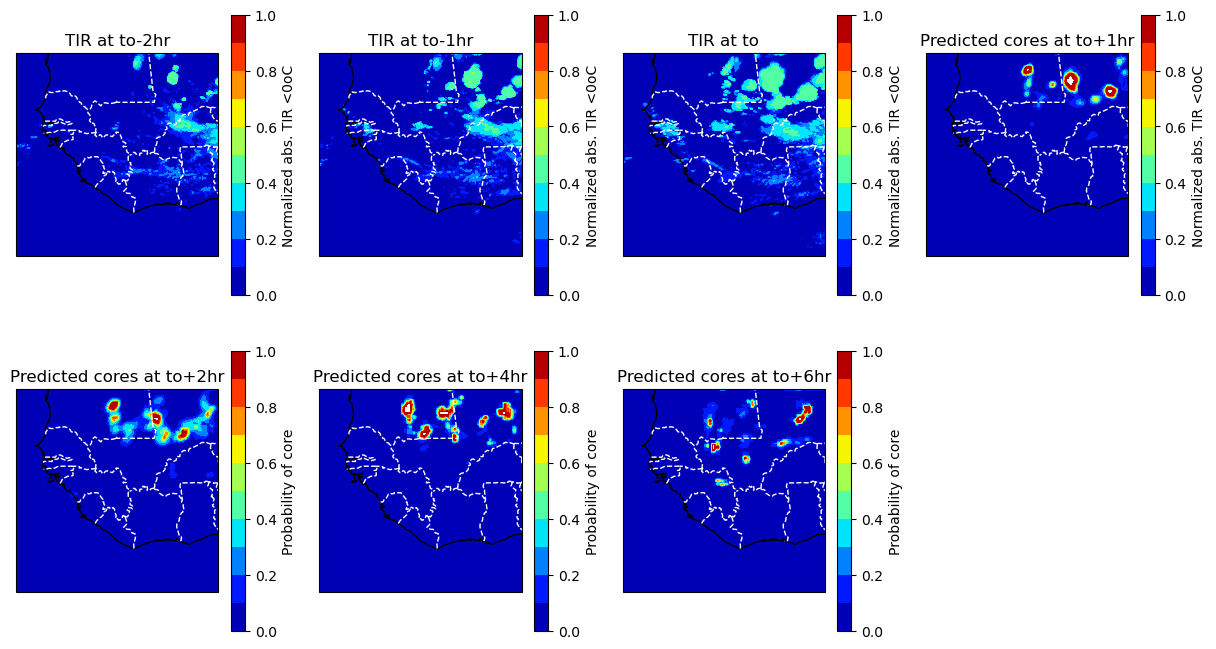

In [11]:
data = np.zeros((7,image_height,image_width))
data[0] = np.squeeze(x_pred[:,:,:,0])
data[1] = np.squeeze(x_pred[:,:,:,1])
data[2] = np.squeeze(x_pred[:,:,:,2])
data[3] = np.squeeze(filtered_image[0][0,:,:,0])
data[4] = np.squeeze(filtered_image[1][0,:,:,0])
data[5] = np.squeeze(filtered_image[2][0,:,:,0])
data[6] = np.squeeze(filtered_image[3][0,:,:,0])

titles = ['TIR at to-2hr','TIR at to-1hr','TIR at to','Predicted cores at to+1hr','Predicted cores at to+2hr','Predicted cores at to+4hr','Predicted cores at to+6hr']
levels_custom=np.arange(0,1.05,0.1)
labels=['Normalized abs. TIR <0oC', 'Probability of core']

fig, axes = plt.subplots(2, 4, figsize=(15, 8), subplot_kw={'projection':ccrs.PlateCarree()})
axes[1][3].set_visible(False)

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, reg_lon[b:], reg_lat[:a], data[idx] ,levels_custom= levels_custom,plot_label=labels[0])
    ax.set_title(titles[idx])

for idx, ax in enumerate(axes[1]):
    if idx==3:
        exit
    else:
        plot_maps_colorbar(ax, reg_lon[b:], reg_lat[:a], data[idx+4],levels_custom= levels_custom,plot_label=labels[1])
        ax.set_title(titles[idx+4])
  
# Print information and display the figure.
print(prediction_time)
plt.show()